Background:

Each price reflects the consensus of value among the mass of market participants at the moment of the trade. A moving average represents an average consensus of value for a selected period of time, it is a composite photo of mass consensus. A longer moving average tracks longer-term consensus, a shorter moving average tracks shorter-term consensus. 

The MACD line is made up of two exponential moving averages. It responds to changes in prices quickly. The signal line smooths the MACD line with another EMA. It responds to changes in prices slower.

Market Psychology:

Crossovers of the MACD and Signal lines identify a shift in the market consensus. When the fast MACD line rises above the Slow signal line it shows, that anticipation of price rises dominate the market. 

When the fast MACD line crosses above the slow Signal line it gives a buy signal.

When the fast MACD line crosses below the slow Signal line it gives a sell signal.


In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime


class Macd:

    '''Back testing a MACD Moving Average Convergence Divergence strategy'''

    def __init__(self, symbol, start, end, amount , ftc = 0.0, ptc = 0.0, verbose = True):
        self.symbol = symbol
        self.start = start
        self.end = end 
        self.initial_amount = amount
        self.amount = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0 
        self.position = 0 
        self.trades = 0
        self.verbose = verbose
        self.get_data()
        self.calc_indicators()
        self.generate_signals()
        msg = f'\n\nRunning MACD Strategy'
        msg += f'\nFixed costs {self.ftc}'
        msg += f'\nProportional costs {self.ptc}'
        print(msg)
        print('=' * 55)

        self.run_strategy()
        self.plot_chart()

       
        
    def get_data(self):
        self.data = yf.download(self.symbol, start = self.start, end = self.end)
        if self.data.empty:
            print('No data pulled')

    def plot_data(self, cols= None):
        if cols is None:
            cols = ['Close']
            self.data['Close'].plot(figsize = (10,6), title = (f"A Graph of {self.symbol} Close Prices"))
        else:
            self.data[cols].plot(figsize = (10,6), title = (f"A Graph of {self.symbol} {cols} Prices"))
   
    # Core methods

    def get_date_price(self,bar):
        rawdate = pd.to_datetime(bar)

        if rawdate in self.data.index:
            price = self.data.loc[bar, 'Close']
            return str(rawdate.date()), price
        else:
            print(f"Date {rawdate} not found in data")

    def print_balance(self, bar):
        date, price = self.get_date_price(bar)
        print(f'{date} | Current Balance: {self.amount:.2f}')

    def print_net_wealth(self, bar):
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | Current Net Wealth: {net_wealth:.2f}')  

    def place_buy_orders(self, bar, units = None, amount = None):
        date, price = self.get_date_price(bar)
        if units is None:
            units = 1
        total_cost = (units*price) + (1 * self.ptc) + self.ftc
        self.amount -= total_cost
        self.units += units
        self.position = 1
        self.trades += 1
        self.data.loc[bar, 'Inventory'] = self.units
        self.data.loc[bar, 'position'] = self.position        
        if self.verbose:
            print(f'{date} | Buying {units} at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            print('=' * 55)

    def place_sell_order(self, bar, units = None , amount = None):
        date, price = self.get_date_price(bar)
        if units is None:
            units = 1
        total_revenue = (units*price) * (1 - self.ptc) - self.ftc
        self.amount += total_revenue
        self.units -= units 
        self.position = 0
        if self.units <= 0:
            self.position = 0
            self.units = 0
        self.trades += 1
        self.data.loc[bar, 'Inventory'] = self.units
        self.data.loc[bar, 'position'] = self.position
        if self.verbose:
            print(f'{date} | Selling {units} at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            print('=' * 55)
    
    def close_out(self, bar):
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = self.units
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
            print('Final balance [$] {:.2f}'.format(self.amount))
            perf = ((self.amount - self.initial_amount) /
                    self.initial_amount * 100)
            print('Net Performance [%] {:.2f}'.format(perf))
            print('Trades executed [#] {:.2f}'.format(self.trades))
            print('=' * 55)    
            
    
    def calc_indicators(self):
        '''Calculate MACD technical indicator
            1) Calculate 12-day EMA of closing prices
            2) Calculate a 26-day EMA of closing prices
            3) Subtract the 26-day EMA from the 12-day EMA and plot their difference as a solid line. This is the FAST MACD line.
            4) Calculate a 9-day EMA of the fast line, this is the SLOW SIGNAL LINE
            '''
        self.data['EMA_12'] = self.data.Close.ewm(span = 12, adjust = False, min_periods = 12).mean()
        self.data['EMA_26'] = self.data.Close.ewm(span = 26, adjust = False, min_periods = 26).mean()
        self.data['MACD Fast'] = self.data['EMA_12'] - self.data['EMA_26']
        self.data['MACD Signal'] = self.data['MACD Fast'].ewm(span = 9, adjust = False).mean()
        self.data.dropna(inplace = True)


    def generate_signals(self):
        ''' Generate Trading Signals'''
        conditions = [(self.data['MACD Fast'] > self.data['MACD Signal']), (self.data['MACD Fast'] <= self.data['MACD Signal'])]
        choices = [1,0]
        default = 0
        self.data['Signal'] = np.select(conditions, choices, default=default)
        self.data.Signal = self.data.Signal.shift()
        self.data.dropna(inplace = True)

    
    def run_strategy(self):
        self.data['signal_change'] = self.data.Signal - self.data.Signal.shift()
        self.data['position'] = np.nan
        self.data['Inventory'] = np.nan
        self.data['Realized_Return'] = 0.0
        self.data['Unrealized_Return'] = 0.0
        self.data['Equity'] = np.nan
        self.buy_price = None
        self.data.loc[self.data['signal_change'] == 1, 'position'] = 1
        self.data.loc[self.data['signal_change'] == -1, 'position'] = 0
        self.data['position'] = self.data['position'].ffill().fillna(0)

        for bar in self.data.index:
            if self.data.loc[bar, 'signal_change'] == 1 and self.position == 0:
                self.place_buy_orders(bar, amount = self.amount, units = 1)
                self.buy_price = self.data.loc[bar, 'Close']

            elif self.data.loc[bar, 'signal_change'] == - 1 and self.position == 1: 
                self.sell_price = self.data.loc[bar, 'Close']
                realized_return = (self.sell_price - self.buy_price) * self.units
                self.place_sell_order(bar, units = self.units)
                self.data.loc[bar, 'Realized_Return'] = realized_return
                self.position = 0  
                self.units = 0
                self.data.loc[bar, 'Unrealized_Return'] = 0.0

            if self.position == 1:
                current_price = self.data.loc[bar, 'Close']
                unrealized_return = (current_price - self.buy_price) * self.units
                self.data.loc[bar, 'Unrealized_Return'] = unrealized_return
            else:
                self.data.loc[bar, 'Unrealized_Return'] = 0.0

            current_price = self.data.loc[bar, 'Close']
            self.data.loc[bar, 'Equity'] = self.amount + (self.units * current_price)
            self.data.loc[bar, 'Inventory'] = self.units

        self.close_out(self.data.index[-1])
        self.data['Inventory'] = self.data['Inventory'].ffill().fillna(0)

        
    def plot_chart(self):

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        buy_signals = self.data[self.data['signal_change'] == 1]
        sell_signals = self.data[self.data['signal_change'] == -1]

        ax1.plot(self.data['Close'], color = 'black')
        ax1.set_title('self Close Prices')
        ax1.set_ylabel('Price')
        ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100)
        ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100)
        ax1.set_title(f'MACD Cross Over Strategy for {self.symbol}')
        ax1.grid()

        ax2.plot(self.data['MACD Fast'], label = 'MACD Fast', color='b')
        ax2.plot(self.data['MACD Signal'], label='MACD Signal', color='orange',  ls = '--')
        ax2.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add a horizontal line at 0 for reference
        ax2.set_title('MACD')
        ax2.set_ylabel('MACD Value')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.show()
     
  
        

    
    

[*********************100%%**********************]  1 of 1 completed




Running MACD Strategy
Fixed costs 0.0
Proportional costs 0.0
2024-02-09 | Buying 1 at 72.13
2024-02-09 | Current Balance: 127.87
2024-02-09 | Current Net Wealth: 200.00
2024-02-21 | Selling 1 at 67.47
2024-02-21 | Current Balance: 195.34
2024-02-21 | Current Net Wealth: 195.34
2024-02-26 | Buying 1 at 79.09
2024-02-26 | Current Balance: 116.25
2024-02-26 | Current Net Wealth: 195.34
2024-03-18 | Selling 1 at 88.46
2024-03-18 | Current Balance: 204.70
2024-03-18 | Current Net Wealth: 204.70
2024-05-01 | Buying 1 at 83.04
2024-05-01 | Current Balance: 121.66
2024-05-01 | Current Net Wealth: 204.70
2024-05-02 | Selling 1 at 85.82
2024-05-02 | Current Balance: 207.48
2024-05-02 | Current Net Wealth: 207.48
2024-05-03 | Buying 1 at 88.79
2024-05-03 | Current Balance: 118.69
2024-05-03 | Current Net Wealth: 207.48
2024-06-25 | Selling 1 at 126.09
2024-06-25 | Current Balance: 244.78
2024-06-25 | Current Net Wealth: 244.78
2024-08-14 | Buying 1 at 118.08
2024-08-14 | Current Balance: 126.70

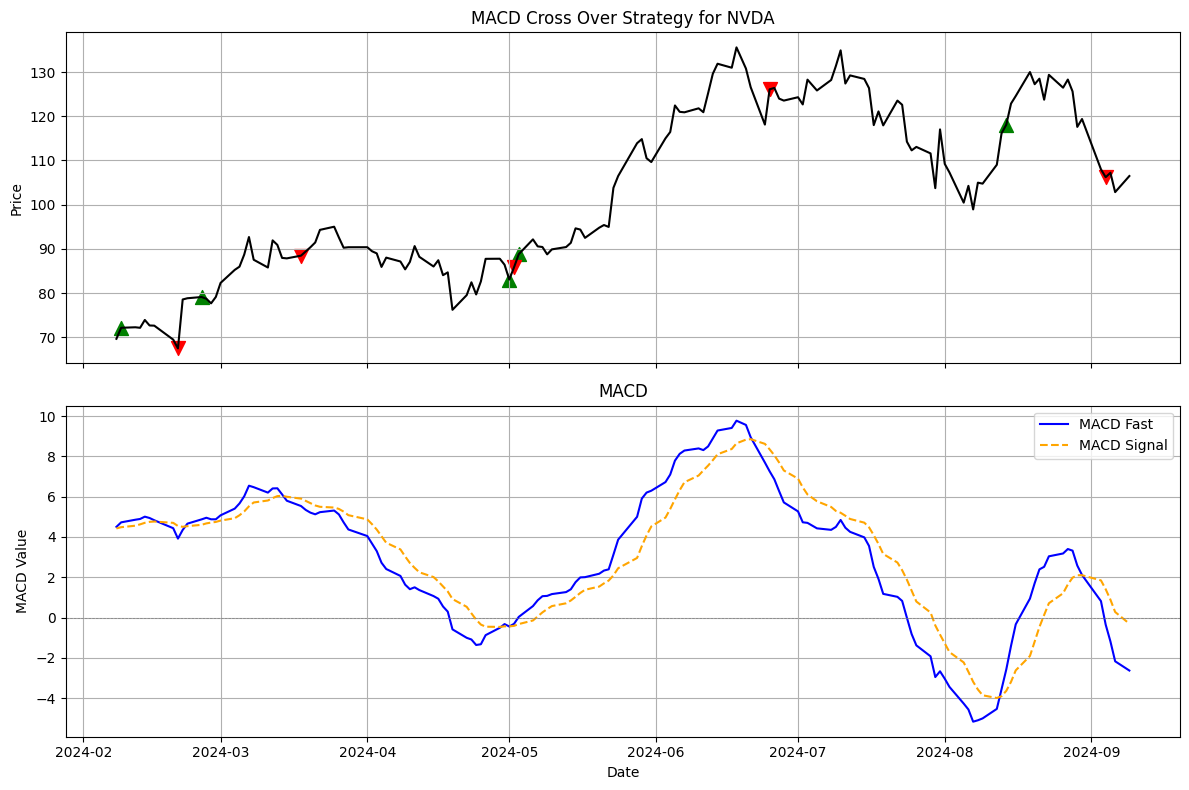

In [136]:
instance = Macd(symbol="NVDA", start="2024-01-01", end = "2024-09-10", amount=200)

In [137]:
view = instance.data

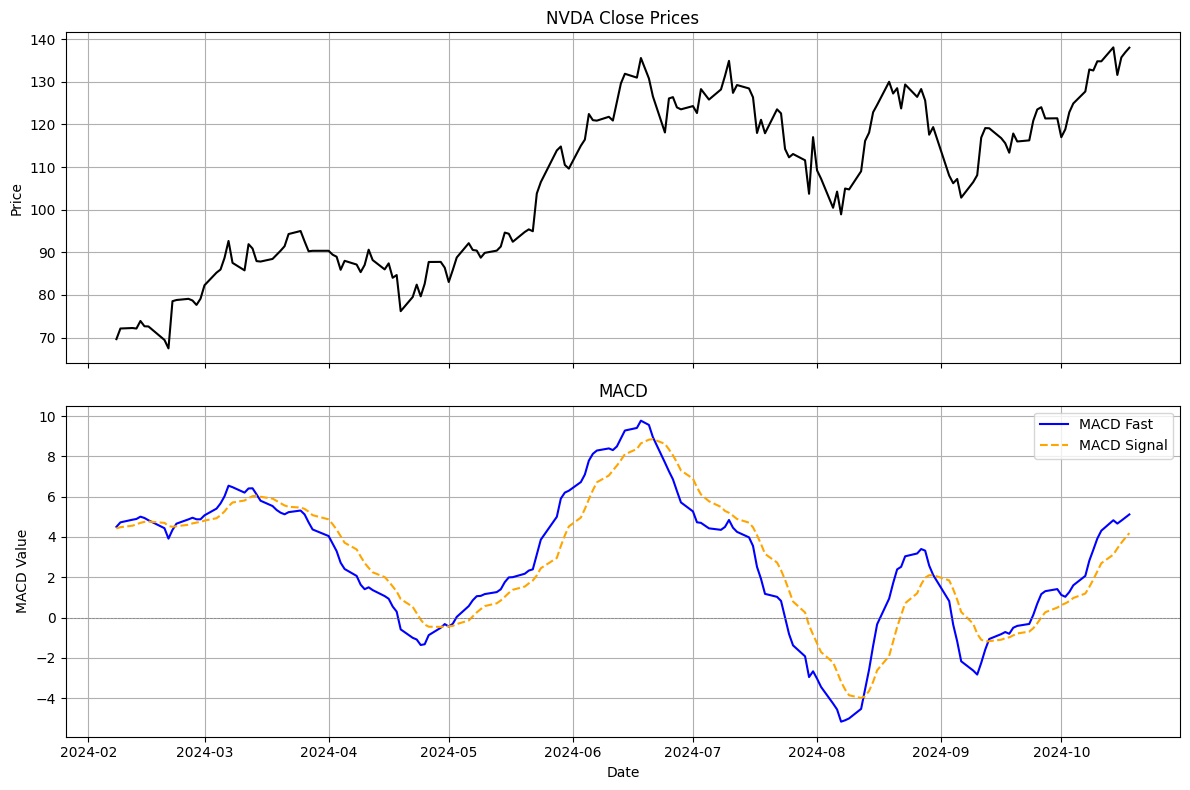

In [138]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(nvda.data['Close'], color = 'black')
ax1.set_title('NVDA Close Prices')
ax1.set_ylabel('Price')
ax1.grid()

ax2.plot(nvda.data['MACD Fast'], label = 'MACD Fast', color='b')
ax2.plot(nvda.data['MACD Signal'], label='MACD Signal', color='orange',  ls = '--')
ax2.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Add a horizontal line at 0 for reference
ax2.set_title('MACD')
ax2.set_ylabel('MACD Value')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()



In [139]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'
    Plot y versus x as lines and/or markers.

    Call signatures::

        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

    The coordinates of the points or line nodes are given by *x*, *y*.

    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.

    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses

    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line pro